In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
 
%matplotlib inline

#Modeling Data Preparation

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/mhealth_human_activity_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Datasets/mhealth_human_activity_data/test.csv')
train.shape,test.shape

((246210, 14), (64342, 14))

In [4]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246210, 12), (246210,), (64342, 12), (64342,))

In [5]:
from scipy import stats
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [6]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_train.shape, y_train.shape

((4923, 100, 12), (4923, 1))

In [7]:
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
X_test.shape, y_test.shape

((1285, 100, 12), (1285, 1))

#Model building

In [8]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 32)           1184      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 32)           128       
_________________________________________________________________
re_lu (ReLU)                 (None, 100, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0

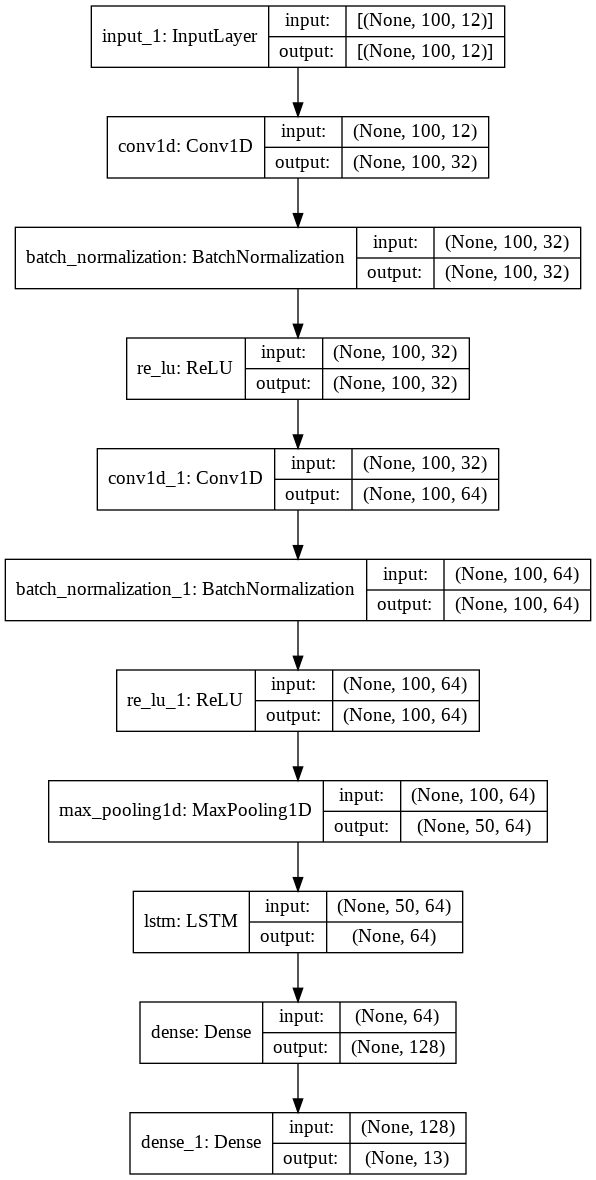

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/mHealth/mhealth_best.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
 
model_history = model.fit(X_train,y_train, epochs= 10, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/10
154/154 [==============================] - 10s 11ms/step - loss: 1.3434 - sparse_categorical_accuracy: 0.6316 - val_loss: 2.3604 - val_sparse_categorical_accuracy: 0.4335
Epoch 2/10
154/154 [==============================] - 1s 6ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.9478 - val_loss: 0.1039 - val_sparse_categorical_accuracy: 0.9619
Epoch 3/10
154/154 [==============================] - 1s 6ms/step - loss: 0.1131 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0763 - val_sparse_categorical_accuracy: 0.9868
Epoch 4/10
154/154 [==============================] - 1s 6ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9749 - val_loss: 0.1048 - val_sparse_categorical_accuracy: 0.9642
Epoch 5/10
154/154 [==============================] - 1s 6ms/step - loss: 0.0680 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0401 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/10
154/154 [==============================] - 1s 6ms/step - loss: 0.0500 - sparse_categori

#Model Evaluation

In [11]:
model_history.history

{'loss': [0.7320249676704407,
  0.1470288634300232,
  0.11146386712789536,
  0.08565961569547653,
  0.06592898070812225,
  0.04270022734999657,
  0.04028807953000069,
  0.042042702436447144,
  0.038826100528240204,
  0.07001158595085144],
 'sparse_categorical_accuracy': [0.7989031076431274,
  0.9547024369239807,
  0.9677026271820068,
  0.9746089577674866,
  0.9809059500694275,
  0.9859841465950012,
  0.9869998097419739,
  0.9867966771125793,
  0.9888279438018799,
  0.9786715507507324],
 'val_loss': [2.360403537750244,
  0.10385996103286743,
  0.07633910328149796,
  0.10480213910341263,
  0.04012876749038696,
  0.2518393099308014,
  0.030126655474305153,
  0.12342976033687592,
  0.06332144886255264,
  0.038284339010715485],
 'val_sparse_categorical_accuracy': [0.43346303701400757,
  0.9618676900863647,
  0.9867704510688782,
  0.964202344417572,
  0.991439700126648,
  0.9470816850662231,
  0.9898832440376282,
  0.9735408425331116,
  0.9821011424064636,
  0.9937742948532104]}

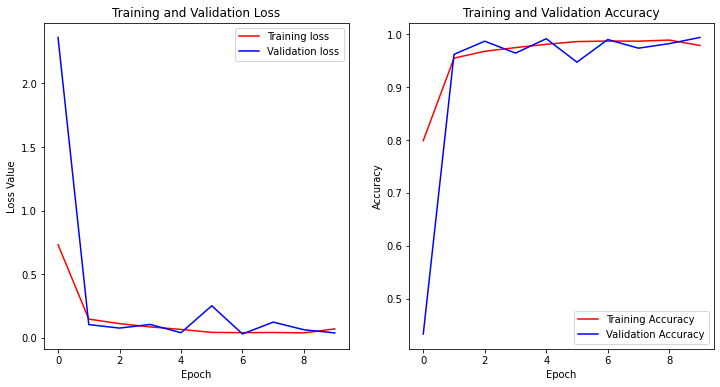

In [12]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/mHealth/mhealth_best.h5")

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

41/41 [==============================] - 0s 3ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9899
Train accuracy 99.15 %
Train loss 0.028401507064700127
Test accuracy 98.99 %
Test loss 0.030126655474305153


In [14]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)

In [15]:
pred.shape,y_test.shape

((1285, 1), (1285, 1))

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
 
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       0.95      0.99      0.97       124
           2       0.99      1.00      1.00       122
           3       1.00      1.00      1.00       124
           4       1.00      0.99      1.00       120
           5       0.99      0.99      0.99        84
           6       0.99      0.93      0.96       104
           7       1.00      0.99      1.00       112
           8       0.99      0.99      0.99       117
           9       0.99      0.99      0.99       121
          10       0.99      1.00      0.99        89
          11       1.00      1.00      1.00        51
          12       1.00      1.00      1.00        27

    accuracy                           0.99      1285
   macro avg       0.99      0.99      0.99      1285
weighted avg       0.99      0.99      0.99      1285

**************************************************
[[ 90   0   0   0   0   0   

In [18]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

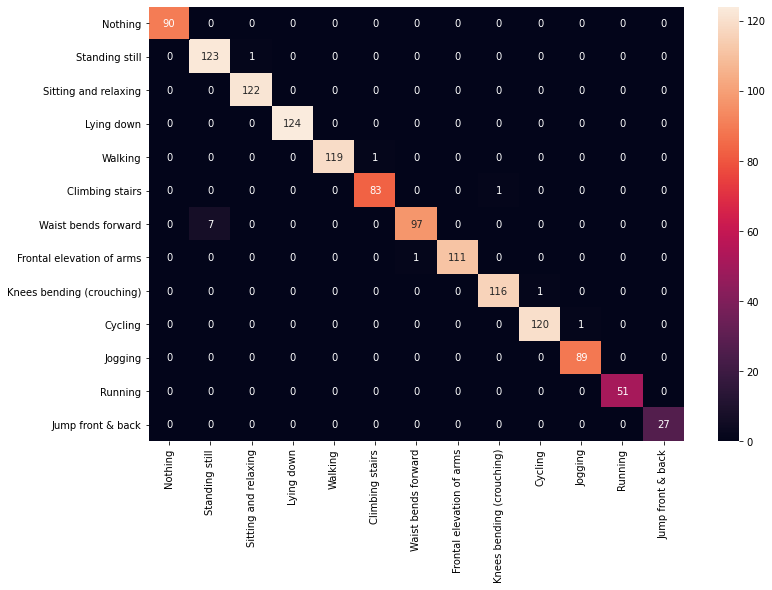

In [19]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()